<a href="https://colab.research.google.com/github/esay2077/video_intelligence/blob/master/%EB%A7%90%ED%83%80%EA%B8%B0%20%EC%9D%B8%EC%8B%9D%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Action Recognition with an Inflated 3D CNN


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/deepmind/i3d-kinetics-400/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This Colab demonstrates recognizing actions in video data using the
[tfhub.dev/deepmind/i3d-kinetics-400/1](https://tfhub.dev/deepmind/i3d-kinetics-400/1) module. More models to detect actions in videos can be found [here](https://tfhub.dev/s?module-type=video-classification).

The underlying model is described in the paper "[Quo Vadis, Action Recognition? A New
Model and the Kinetics Dataset](https://arxiv.org/abs/1705.07750)" by Joao
Carreira and Andrew Zisserman. The paper was posted on arXiv in May 2017, and
was published as a CVPR 2017 conference paper.
The source code is publicly available on
[github](https://github.com/deepmind/kinetics-i3d).

"Quo Vadis" introduced a new architecture for video classification, the Inflated
3D Convnet or I3D. This architecture achieved state-of-the-art results on the UCF101
and HMDB51 datasets from fine-tuning these models. I3D models pre-trained on Kinetics
also placed first in the CVPR 2017 [Charades challenge](http://vuchallenge.org/charades.html).

The original module was trained on the [kinetics-400 dateset](https://deepmind.com/research/open-source/open-source-datasets/kinetics/)
and knows about 400 different actions.
Labels for these actions can be found in the
[label map file](https://github.com/deepmind/kinetics-i3d/blob/master/data/label_map.txt).

In this Colab we will use it recognize activites in videos from a UCF101 dataset.

## Setup

In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [ ]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetchs a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

In [ ]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

# Using the UCF101 dataset

In [ ]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()
  
categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))


In [ ]:
# Get a sample cricket video.
video_path = fetch_ucf_video("v_CricketShot_g04_c02.avi")
sample_video = load_video(video_path)

In [ ]:
sample_video.shape

In [ ]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

Run the id3 model and print the top-5 action predictions.

In [ ]:
def predict(sample_video):
  # Add a batch axis to the to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [ ]:
predict(sample_video)

Now try a new video, from: https://commons.wikimedia.org/wiki/Category:Videos_of_sports

How about [this video](https://commons.wikimedia.org/wiki/File:End_of_a_jam.ogv) by Patrick Gillett: 

In [ ]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/7/74/Horses_in_Rome.webm

In [ ]:
video_path = "Horses_in_Rome.webm"

In [ ]:
sample_video = load_video(video_path)[:100]
sample_video.shape

In [ ]:
to_gif(sample_video)

In [ ]:
predict(sample_video)

밑에는 결과 사진 첨부

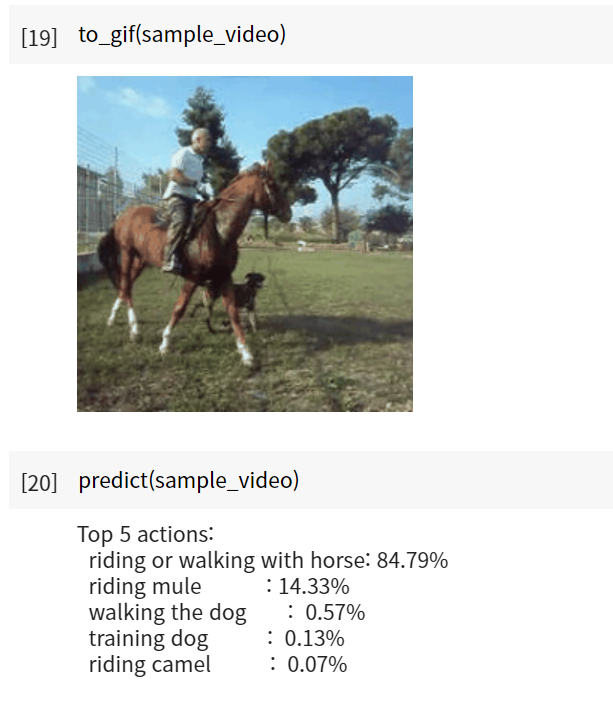